# Recommendation Systems Assignment

### MIE451/1513 UofT

## Imports

In [1]:
# import required libraries
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from scipy import stats

## Support functions and variables

In [2]:
# !unzip ml-100k.zip -d .

In [3]:
MOVIELENS_DIR = "ml-100k"

In [4]:
!ls {MOVIELENS_DIR}

README
allbut.pl
mku.sh
u.data
u.genre
u.info
u.item
u.occupation
u.user
u1.base
u1.test
u2.base
u2.test
u3.base
u3.test
u4.base
u4.test
u5.base
u5.test
ua.base
ua.test
ub.base
ub.test


In [5]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [6]:
rating_df = getData(MOVIELENS_DIR, 'u.data')
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


In [8]:
# train_df = getData(MOVIELENS_DIR, 'u1.base')
# test_df = getData(MOVIELENS_DIR, 'u1.test')

# # test number of records (total should be 100K)
# print("# of lines in train:", train_df.shape[0])
# print("# of lines in test:", test_df.shape[0])

## Q1

### (a)

In [9]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. row IDs are (userID-1), columns IDs are (itemID-1),
            and the rating for (userID,itemID,rating) is the value at this row and column.  
            Any observed ratings are zero.
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
              
    """
    matrix = np.zeros((num_users, num_items))
    ########### your code goes here ###########
    tmp_df = rating_df[['userID', 'itemID', 'rating']]
    
    # Populate the matrix based on the dataset
    for (userID, itemID, rating) in tmp_df.itertuples(index=False):
        matrix[userID-1, itemID-1] = rating
    
    ###########         end         ###########
    return matrix

In [10]:
dataPreprocessor(rating_df, num_users, num_items)

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [11]:
# train_matrix = dataPreprocessor(train_df, num_users, num_items)
# train_matrix.shape

### (b)

In [12]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array. this is the same dimensions and 
                row/column IDs as train_matrix, but anywhere there is a 0 in train_matrix, 
                there should be a predicted value in predictedMatrix.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'  
            
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########

        for (user, item), rating in np.ndenumerate(train_matrix):
            # Extract the items the user already rated
            user_vector = train_matrix[user, :]
            rated_items = user_vector[user_vector.nonzero()]

            # If not empty, calculate average and set as rating for the current item
            item_avg = rated_items.mean() if rated_items.size else 0
            predictionMatrix[user, item] = item_avg

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array. this is the same dimensions and 
                row/column IDs as train_matrix, but anywhere there is a 0 in train_matrix, 
                there should be a predicted value in predictedMatrix.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        item_popularity = np.zeros((num_items))
        for item in range(num_items):
            num_users_rated = len(train_matrix[:, item].nonzero()[0])
            num_users_liked = len(vf(train_matrix[:, item]).nonzero()[0])
            
            item_popularity[item] = num_users_liked / num_users_rated if num_users_rated else 0
            
        for (user, item), rating in np.ndenumerate(train_matrix):
            predictionMatrix[user, item] = item_popularity[item]        
                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, userID, itemID) in tqdm(prediction[['userID', 'itemID']].itertuples()):
            prediction.ix[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [13]:
popularity_recsys = BaseLineRecSys('popularity')

In [14]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

In [15]:
popularity_recsys.getModel()

array([[ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [17]:
popularity_recsys.evaluate_test(rating_df, copy=True).head()

0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:104: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
100000it [01:08, 1459.18it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [18]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [19]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [20]:
average_user_rating_recsys.getModel()

array([[ 3.61029412,  3.61029412,  3.61029412, ...,  3.61029412,
         3.61029412,  3.61029412],
       [ 3.70967742,  3.70967742,  3.70967742, ...,  3.70967742,
         3.70967742,  3.70967742],
       [ 2.7962963 ,  2.7962963 ,  2.7962963 , ...,  2.7962963 ,
         2.7962963 ,  2.7962963 ],
       ..., 
       [ 4.04545455,  4.04545455,  4.04545455, ...,  4.04545455,
         4.04545455,  4.04545455],
       [ 4.26582278,  4.26582278,  4.26582278, ...,  4.26582278,
         4.26582278,  4.26582278],
       [ 3.41071429,  3.41071429,  3.41071429, ...,  3.41071429,
         3.41071429,  3.41071429]])

In [21]:
average_user_rating_recsys.evaluate_test(rating_df, copy=True).head()

0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:104: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
100000it [01:08, 1460.52it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)

In [22]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        
        INPUT
            matrix: same as the rating matrix generated by dataPreprocessor 
            with R rows and C columns.  Outputs an R x R similarity_matrix S 
            where each S_ij should be the euclidean similarity between row i and 
            row j of matrix.
        """
        ########### your code goes here ###########
        
        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric='euclidean'))
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
            
        INPUT
            matrix: same as the rating matrix generated by dataPreprocessor 
            with R rows and C columns.  Outputs an R x R similarity_matrix S 
            where each S_ij should be the somethingelse similarity between row i and 
            row j of matrix.
        """
        ########### your code goes here ###########
        
        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric='manhattan'))
        
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.__model
                
                self.__model: this is the same dimensions and row/column IDs as train_matrix, 
                but anywhere there is a 0 in train_matrix, there should be a predicted value 
                in self.__model.
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see 'vectorizedUserSimRecSys' code in for an efficient vectorized example)
                
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########

            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            
            uu_similarity = self.cosine(train_matrix)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix) / normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            
            useraverage = np.sum(train_matrix, axis=1) / np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

            self.__model = predictionMatrix
            
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########

            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            
            ii_similarity = self.cosine(train_matrix.T)
            normalizer = np.matmul(temp_matrix, ii_similarity)
            normalizer[normalizer == 0] = 1e-5
            
            predictionMatrix = np.matmul(train_matrix, ii_similarity) / normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            
            useraverage = np.sum(train_matrix, axis=1) / np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            
            self.__model = predictionMatrix
            
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, userID, itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.ix[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [23]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [24]:
SimBasedRecSys.euclidean(I)

array([[ 1.        ,  0.41421356,  0.41421356],
       [ 0.41421356,  1.        ,  0.41421356],
       [ 0.41421356,  0.41421356,  1.        ]])

In [25]:
SimBasedRecSys.somethingelse(I)

array([[ 1.        ,  0.33333333,  0.33333333],
       [ 0.33333333,  1.        ,  0.33333333],
       [ 0.33333333,  0.33333333,  1.        ]])

### (b)

Manhattan distance is measured by absolute difference (L1 norm), which is potentially more robust than euclidean (L2 norm) in terms of noise. Eucldiean distance will exagerate discrepancy as Manhattan would not.

## Q3

### (a)

In [26]:
user_cosine_recsys = SimBasedRecSys('user', 'cosine')

In [27]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [28]:
user_cosine_recsys.getModel()

array([[ 3.89911175,  3.19022667,  3.0261129 , ...,  2.        ,
         3.        ,  3.        ],
       [ 3.84034456,  3.17139889,  2.92626717, ...,  2.        ,
         3.        ,  3.        ],
       [ 3.87104065,  3.12823798,  3.03250708, ...,  2.        ,
         3.        ,  3.        ],
       ..., 
       [ 3.90754645,  3.20227238,  3.05776201, ...,  2.        ,
         3.        ,  3.        ],
       [ 3.91100649,  3.21591021,  2.98854017, ...,  2.        ,
         3.        ,  3.        ],
       [ 3.91593122,  3.24268207,  3.08255897, ...,  0.        ,
         3.        ,  3.        ]])

In [29]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [30]:
user_cosine_recsys.evaluate_test(rating_df, copy=True).head()

0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:162: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
100000it [01:09, 1444.36it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [31]:
item_cosine_recsys = SimBasedRecSys('item', 'cosine')

In [32]:
item_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [33]:
item_cosine_recsys.getModel()

array([[ 3.75429099,  3.66419957,  3.73222997, ...,  3.60248287,
         3.79662696,  3.90232044],
       [ 3.83658867,  3.80424519,  3.77473905, ...,  3.72798332,
         3.9109779 ,  3.79775927],
       [ 2.84492718,  2.89389328,  2.84327324, ...,  2.99504451,
         3.16444153,  2.9858119 ],
       ..., 
       [ 4.11427954,  4.0558267 ,  4.00963139, ...,  4.        ,
         3.87872799,  4.14814803],
       [ 4.37096823,  4.39679254,  4.33543016, ...,  3.955358  ,
         4.41891089,  4.57995134],
       [ 3.52030345,  3.46948821,  3.52393064, ...,  0.        ,
         3.6110641 ,  3.59656861]])

In [34]:
item_cosine_recsys.evaluate_test(rating_df, copy=True).head()

0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:162: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
100000it [01:13, 1355.92it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [35]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = len([item for item in topK if item in userTestVector]) / len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return sumPrecisions / countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = len([item for item in topK if item in userTestVector]) / len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return sumRecalls / countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID', 'itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base', 'u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
            scores[algorithm.getPredColName()] = fold_scores
            
        results = scores    
    
        return results
            

In [36]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    mu, sd = np.mean(a), np.std(a)
    z = stats.t.ppf(confidence, n)
    h = z * sd / sqrt(n)
    return mu, h

In [37]:
algorithm_instances = [user_cosine_recsys, item_cosine_recsys]

In [38]:
cv_rmse = CrossValidation('RMSE')

In [39]:
cv_results = cv_rmse.run(algorithm_instances, num_users, num_items, k=10)

Processing algorithm user-cosine


0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:162: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
20000it [00:10, 1826.00it/s]
20000it [00:10, 1921.91it/s]
20000it [00:10, 1887.89it/s]
20000it [00:10, 1927.70it/s]
20000it [00:10, 1893.48it/s]


Processing algorithm item-cosine


20000it [00:09, 2022.09it/s]
20000it [00:10, 1965.64it/s]
20000it [00:11, 1782.72it/s]
20000it [00:10, 1945.27it/s]
20000it [00:11, 1807.90it/s]


In [40]:
uu_mean, uu_ci = mean_confidence_interval(cv_results['user-cosine'])
ii_mean, ii_ci = mean_confidence_interval(cv_results['item-cosine'])
print("Mean and CI of user-user: {}, {}\nMean and CI of item-item: {}, {}.".format(uu_mean, uu_ci, ii_mean, ii_ci))

Mean and CI of user-user: 1.0222144360078134, 0.005344918412078359
Mean and CI of item-item: 1.0200829001062477, 0.008606767637174193.


From the results, it is hard to differentiate between the two as they are overlapped. Since we have more items than users (items 1682, user 943), the user-user based may perform better because the average number of rating per user will be higher than per item. With less user than items in the system, each item tends to have less ratings than each user.

## Q4

### (a)

#### RMSE

In [41]:
algorithm_instances = [popularity_recsys, average_user_rating_recsys, user_cosine_recsys, item_cosine_recsys]

In [42]:
cv_rmse = CrossValidation('RMSE')

In [43]:
cv_rmse_res = cv_rmse.run(algorithm_instances, num_users, num_items, k=10)

Processing algorithm popularity


0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:104: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
20000it [00:12, 1553.39it/s]
20000it [00:10, 1831.17it/s]
20000it [00:11, 1746.24it/s]
20000it [00:13, 1483.19it/s]
20000it [00:10, 1960.17it/s]


Processing algorithm useraverage


20000it [00:11, 1797.74it/s]
20000it [00:10, 1972.25it/s]
20000it [00:10, 1957.17it/s]
20000it [00:10, 1966.19it/s]
20000it [00:09, 2015.67it/s]


Processing algorithm user-cosine


20000it [00:09, 2006.26it/s]
20000it [00:10, 1999.99it/s]
20000it [00:10, 1996.87it/s]
20000it [00:09, 2081.29it/s]
20000it [00:09, 2038.20it/s]


Processing algorithm item-cosine


20000it [00:09, 2064.50it/s]
20000it [00:10, 1921.91it/s]
20000it [00:11, 1753.41it/s]
20000it [00:10, 1910.44it/s]
20000it [00:10, 1893.48it/s]


In [44]:
pp_mean, pp_ci = mean_confidence_interval(cv_rmse_res['popularity'])
ua_mean, ua_ci = mean_confidence_interval(cv_rmse_res['useraverage'])
uu_mean, uu_ci = mean_confidence_interval(cv_rmse_res['user-cosine'])
ii_mean, ii_ci = mean_confidence_interval(cv_rmse_res['item-cosine'])
print("Mean and CI of popularity: {}, {}\nMean and CI of user-average: {}, {}".format(pp_mean, pp_ci, ua_mean, ua_ci))
print("Mean and CI of user-user: {}, {}\nMean and CI of item-item: {}, {}".format(uu_mean, uu_ci, ii_mean, ii_ci))

Mean and CI of popularity: 3.1590928909890112, 0.012853154473572641
Mean and CI of user-average: 1.0437176561595025, 0.009599098624283816
Mean and CI of user-user: 1.0222144360078134, 0.005344918412078359
Mean and CI of item-item: 1.0200829001062477, 0.008606767637174193


#### P@K

In [45]:
cv_patk = CrossValidation('P@K')

In [46]:
cv_patk_res = cv_patk.run(algorithm_instances, num_users, num_items, k=5)

Processing algorithm popularity


0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:104: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
20000it [00:10, 1868.60it/s]
20000it [00:11, 1711.22it/s]
20000it [00:10, 1939.38it/s]
20000it [00:10, 1942.33it/s]
20000it [00:10, 1960.17it/s]


Processing algorithm useraverage


20000it [00:09, 2003.12it/s]
20000it [00:10, 1921.91it/s]
20000it [00:10, 1963.01it/s]
20000it [00:10, 1921.80it/s]
20000it [00:10, 1978.27it/s]


Processing algorithm user-cosine


20000it [00:10, 1910.36it/s]
20000it [00:09, 2067.77it/s]
20000it [00:10, 1828.50it/s]
20000it [00:11, 1812.97it/s]
20000it [00:10, 1945.23it/s]


Processing algorithm item-cosine


20000it [00:11, 1805.31it/s]
20000it [00:10, 1860.42it/s]
20000it [00:15, 1294.20it/s]
20000it [00:12, 1636.79it/s]
20000it [00:10, 1978.32it/s]


In [47]:
pp_mean, pp_ci = mean_confidence_interval(cv_patk_res['popularity'])
ua_mean, ua_ci = mean_confidence_interval(cv_patk_res['useraverage'])
uu_mean, uu_ci = mean_confidence_interval(cv_patk_res['user-cosine'])
ii_mean, ii_ci = mean_confidence_interval(cv_patk_res['item-cosine'])
print("Mean and CI of popularity: {}, {}\nMean and CI of user-average: {}, {}".format(pp_mean, pp_ci, ua_mean, ua_ci))
print("Mean and CI of user-user: {}, {}\nMean and CI of item-item: {}, {}".format(uu_mean, uu_ci, ii_mean, ii_ci))

Mean and CI of popularity: 0.5505832449628855, 0.09421819530259093
Mean and CI of user-average: 0.4736373276776259, 0.08545210012578403
Mean and CI of user-user: 0.5558430540827157, 0.09493385045164594
Mean and CI of item-item: 0.5322163308589621, 0.0964082200644799


#### R@K

In [48]:
cv_ratk = CrossValidation('R@K')

In [49]:
cv_ratk_res = cv_ratk.run(algorithm_instances, num_users, num_items, k=10)

Processing algorithm popularity


0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:104: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
20000it [00:11, 1684.18it/s]
20000it [00:10, 1948.21it/s]
20000it [00:11, 1807.87it/s]
20000it [00:10, 1939.36it/s]
20000it [00:10, 1984.45it/s]


Processing algorithm useraverage


20000it [00:10, 1966.18it/s]
20000it [00:10, 1936.46it/s]
20000it [00:10, 1899.08it/s]
20000it [00:09, 2077.81it/s]
20000it [00:10, 1857.74it/s]


Processing algorithm user-cosine


20000it [00:10, 1836.42it/s]
20000it [00:09, 2057.85it/s]
20000it [00:09, 2098.36it/s]
20000it [00:09, 2081.27it/s]
20000it [00:11, 1770.38it/s]


Processing algorithm item-cosine


20000it [00:11, 1810.44it/s]
20000it [00:09, 2071.17it/s]
20000it [00:09, 2061.16it/s]
20000it [00:09, 2088.06it/s]
20000it [00:09, 2009.39it/s]


In [50]:
pp_mean, pp_ci = mean_confidence_interval(cv_ratk_res['popularity'])
ua_mean, ua_ci = mean_confidence_interval(cv_ratk_res['useraverage'])
uu_mean, uu_ci = mean_confidence_interval(cv_ratk_res['user-cosine'])
ii_mean, ii_ci = mean_confidence_interval(cv_ratk_res['item-cosine'])
print("Mean and CI of popularity: {}, {}\nMean and CI of user-average: {}, {}".format(pp_mean, pp_ci, ua_mean, ua_ci))
print("Mean and CI of user-user: {}, {}\nMean and CI of item-item: {}, {}".format(uu_mean, uu_ci, ii_mean, ii_ci))

Mean and CI of popularity: 0.6760323960342306, 0.07000599530205281
Mean and CI of user-average: 0.640923730991057, 0.07116353710689997
Mean and CI of user-user: 0.6790988820236071, 0.06955582358236294
Mean and CI of item-item: 0.6755644944303931, 0.07128193480106312


### (b)

For baseline using user average, the ranking metric such as P@K and R@K are not meaningful, as the values are all the same.
For baseline using popularity, the RMSE is meaningless because the popularity score of each item per user is normalized to a fraction of number of user liked with number of user rated (scale 0 to 1), which is no longer valid to compare with the raw rating (scale 1 to 5).

### (c)

For each measure, user-cosine performs the best and reason is provided in Q3(b).

### (d)

Not necessarily, because RMSE measures how well the rating is predicted, while the ranking metrices like P@K and R@K meausres how well the recommended items @K that are relevent rank with each other.

## Q5

### (a)

In [51]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
movies_df = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

movies_df.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [52]:
def itemTopK(moviesSim, moviesDataset, itemID, k):
    topK = np.argsort(moviesSim[itemID-1])[::-1][1:k+1]
    namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], topK))
    return namesTopK

In [53]:
rating_matrix = dataPreprocessor(rating_df, num_users, num_items)

In [54]:
movie_sim = SimBasedRecSys.cosine(rating_matrix.T)

In [55]:
# Se7en (ID 11)
itemTopK(movie_sim, movies_df, 11, 5)

['Pulp Fiction (1994)',
 'Braveheart (1995)',
 'Usual Suspects, The (1995)',
 'Fugitive, The (1993)',
 'Terminator, The (1984)']

In [56]:
# The Usual Suspect (ID 12)
itemTopK(movie_sim, movies_df, 12, 5)

['Pulp Fiction (1994)',
 'Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)',
 'Seven (Se7en) (1995)',
 'Raiders of the Lost Ark (1981)']

In [57]:
# Vertigo (ID 479)
itemTopK(movie_sim, movies_df, 479, 5)

['Rear Window (1954)',
 'North by Northwest (1959)',
 'Citizen Kane (1941)',
 'Casablanca (1942)',
 'Psycho (1960)']

### (b)

The similarity results make a lot sense. For the film like Se7en or The Usual Suspect is well known thriller films, the genre of films generated by similarity ranking tends to be thriller because the users who rated the film and films in the results tend to favor the thriller films. This is more evident for the film Vertigo which is a famous Hitchcock thriller classic, and we can see that there are other two Hitchcock thriller classics (Rear Window and Psycho) included in the similar results.

## Q6 [GRAD ONLY]

### (a)

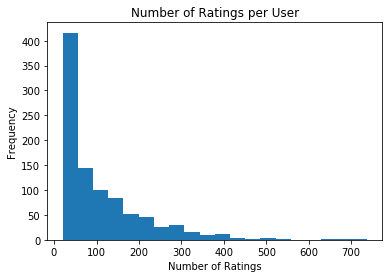

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

rating_freq = [np.size(rating_matrix[i, :].nonzero()) for i in range(rating_matrix.shape[0])]

ax = plt.subplot(111)
plt.hist(rating_freq, bins=20)
plt.title("Number of Ratings per User")
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Ratings')
plt.show()

In [59]:
rating_tau = np.mean(rating_freq)
print("Number of rating threshold:", rating_tau)

Number of rating threshold: 106.044538706


In [60]:
# vf_tau = np.vectorize(lambda x: 1 if x >= rating_tau else 0)
userid_above = [rating_freq.index(i) + 1 for i in rating_freq if i >= rating_tau]
userid_below = [rating_freq.index(i) + 1 for i in rating_freq if i < rating_tau]
# print(userid_above)
print("Number of users with above the threshold:", len(userid_above))
print("Number of users with below the threshold:", len(userid_below))

Number of users with above the threshold: 339
Number of users with below the threshold: 604


In [61]:
# abovetau_df = rating_df.loc[rating_df.userID.isin(userid_above)]
# belowtau_df = rating_df.loc[rating_df.userID.isin(userid_below)]

In [62]:
algorithm_instances = [user_cosine_recsys, item_cosine_recsys]

In [63]:
cv_rmse = CrossValidation('RMSE')

In [64]:
folds = cv_rmse._getData(MOVIELENS_DIR)
folds_above = [[fold[0].loc[fold[0].userID.isin(userid_above)], fold[1]] for fold in folds]
folds_below = [[fold[0].loc[fold[0].userID.isin(userid_below)], fold[1]] for fold in folds]

In [65]:
def customized_folds_run(cv_object, folds, algorithms, num_users, num_items, k=1):
    scores = {}
    for algorithm in algorithms:
        print('Processing algorithm {0}'.format(algorithm.getPredColName()))
        fold_scores = []
        for fold in folds:
            algorithm.reset()
            algorithm.predict_all(fold[0], num_users, num_items)
            prediction = algorithm.evaluate_test(fold[1])
            pred_col = algorithm.getPredColName()
            fold_scores.append(cv_object.rmse(prediction, k, num_users, num_items, pred_col))
        scores[algorithm.getPredColName()] = fold_scores

    results = scores
    return results

#### Above threshold

In [66]:
cv_results_above = customized_folds_run(cv_rmse, folds_above, algorithm_instances, num_users, num_items, k=1)

Processing algorithm user-cosine


0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:162: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
20000it [00:10, 1879.57it/s]
20000it [00:10, 1857.74it/s]
20000it [00:10, 1820.74it/s]
20000it [00:11, 1785.19it/s]
20000it [00:16, 1182.98it/s]


Processing algorithm item-cosine


20000it [00:15, 1296.85it/s]
20000it [00:14, 1341.70it/s]
20000it [00:12, 1551.50it/s]
20000it [00:13, 1520.17it/s]
20000it [00:10, 1844.36it/s]


In [67]:
uu_mean, uu_ci = mean_confidence_interval(cv_results_above['user-cosine'])
ii_mean, ii_ci = mean_confidence_interval(cv_results_above['item-cosine'])
print("Mean and CI of user-user: {}, {}\nMean and CI of item-item: {}, {}.".format(uu_mean, uu_ci, ii_mean, ii_ci))

Mean and CI of user-user: 2.814191591311526, 0.19183627405860781
Mean and CI of item-item: 2.814638996379464, 0.19142310782460037.


#### Below threshold

In [68]:
cv_results_below = customized_folds_run(cv_rmse, folds_below, algorithm_instances, num_users, num_items, k=1)

Processing algorithm user-cosine


20000it [00:10, 1871.32it/s]
20000it [00:13, 1476.34it/s]
20000it [00:11, 1760.64it/s]
20000it [00:09, 2031.72it/s]
20000it [00:10, 1863.15it/s]


Processing algorithm item-cosine


20000it [00:09, 2009.39it/s]
20000it [00:11, 1807.92it/s]
20000it [00:10, 1936.44it/s]
20000it [00:09, 2018.90it/s]
20000it [00:09, 2034.79it/s]


In [69]:
uu_mean, uu_ci = mean_confidence_interval(cv_results_below['user-cosine'])
ii_mean, ii_ci = mean_confidence_interval(cv_results_below['item-cosine'])
print("Mean and CI of user-user: {}, {}\nMean and CI of item-item: {}, {}.".format(uu_mean, uu_ci, ii_mean, ii_ci))

Mean and CI of user-user: 3.6158162621924115, 0.036697106411336826
Mean and CI of item-item: 3.614474498247632, 0.037293367230477825.


The threshold is chosen to use the mean of the number of rating per user. As seen above, the results of the above-threshold type of user are way better than the below-threshold type of user. This is because the number of user above (339) is less than the number of user below (604), meaning the rating per user in the above-group are more than that in the below-group and the above-group has more information can be drew from to predict less items and vice versa.

# Validation

In [70]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [71]:
def testDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [72]:
validation_df = testDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [73]:
def testPopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [74]:
testPopularityRecSys()

### User Average Based Recommendation

In [75]:
def testUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('average_user_rating')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [76]:
testPopularityRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [77]:
def testEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [78]:
testEuclidean()

### Customized Similarity Function (test somethingelse function)

In [79]:
def testCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [80]:
testCustomizedSim()

### User-User Similarity Based Recommendation System

In [81]:
def testUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please contact TA if you see this.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [82]:
testUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [83]:
def testIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please contact TA if you see this.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [84]:
testIISimBasedRecSys()